<a href="https://colab.research.google.com/github/msivakumar47/SIVAKUMAR-M/blob/main/k_means_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# K-Means From Scratch (NumPy only)

# **Objective:** Implement K-Means clustering completely from scratch using only NumPy and Matplotlib. This notebook includes:

# - K-Means++ initialization (from scratch)
# - Manual Euclidean distance (NumPy)
# - Inertia (within-cluster sum of squares)
# - Manual silhouette score implementation
# - Experiments for K = 2, 3, 4 (three runs each)
# - Visualizations and a final conclusion

# > **Important:** This notebook intentionally avoids using scikit-learn or SciPy so it satisfies strict "from-scratch" project rules. If you later want to compare results with scikit-learn, an optional commented cell is provided at the end.
# Imports and global settings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For reproducibility
RND = 42
np.random.seed(RND)

# Matplotlib settings
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12

Dataset shape: (500, 2)


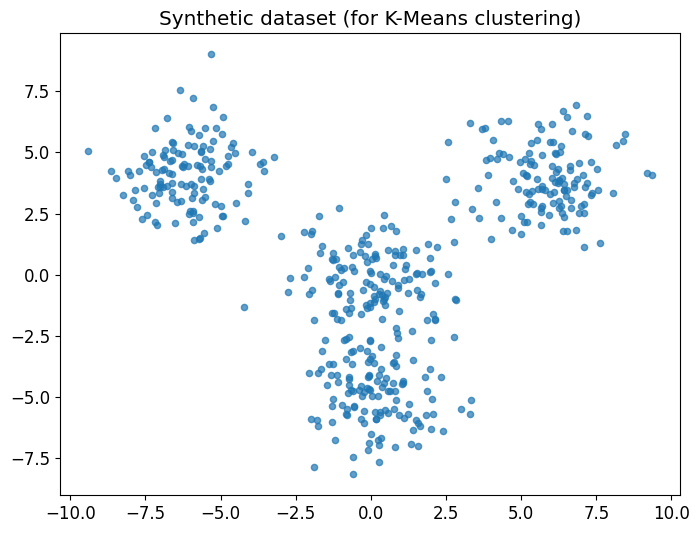

In [40]:
# ## Dataset creation
# We generate a synthetic 2D dataset using NumPy to make cluster visualizations simple and clear for the evaluator.

# - 500 samples
# - 4 centers (so that K=2,3,4 experiments are meaningful)
# - `cluster_std` set so clusters have some overlap (realistic)
# Synthetic dataset generation (NumPy only)
# We'll create four gaussian clusters manually

def make_gaussian_blobs(centers, n_samples=500, cluster_std=1.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    centers = np.array(centers)
    k = len(centers)
    samples_per_center = n_samples // k
    X_list = []
    y_list = []
    for i, c in enumerate(centers):
        pts = np.random.randn(samples_per_center, centers.shape[1]) * cluster_std + c
        X_list.append(pts)
        y_list.extend([i] * samples_per_center)
    X = np.vstack(X_list)
    y = np.array(y_list)
    # If n_samples not divisible, add extra from first center
    if len(X) < n_samples:
        extra = n_samples - len(X)
        extra_pts = np.random.randn(extra, centers.shape[1]) * cluster_std + centers[0]
        X = np.vstack([X, extra_pts])
        y = np.concatenate([y, np.zeros(extra, dtype=int)])
    return X, y

# Define centers
true_centers = [[-6, 4], [0, 0], [6, 4], [0, -5]]
X, y_true = make_gaussian_blobs(true_centers, n_samples=500, cluster_std=1.3, random_state=RND)

print('Dataset shape:', X.shape)
plt.scatter(X[:,0], X[:,1], s=20, alpha=0.7)
plt.title('Synthetic dataset (for K-Means clustering)')
plt.show()

Initial centers (KMeans++):
[[-7.79097018  2.78082745]
 [-0.04509035 -4.69552085]
 [-0.66802699 -1.37697758]
 [ 5.53074398  5.50712874]]


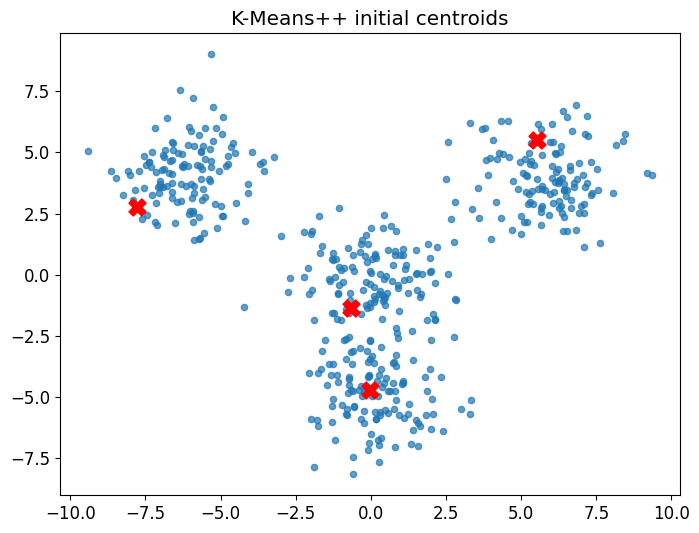

In [42]:
# ## Distance function and K-Means++ initialization
# We implement Euclidean distance using pure NumPy and K-Means++ to select initial centroids in a probabilistic way (recommended for better convergence).
def euclidean_distance(X, C):
    """
    Compute pairwise Euclidean distances between each point in X and each centroid in C.
    X: (n_samples, n_features)
    C: (k, n_features)
    returns: distances shape (n_samples, k)
    """
    # broadcasting: (n_samples, 1, n_features) - (1, k, n_features) -> (n_samples, k, n_features)
    return np.sqrt(((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2))

def kmeans_plus_plus_init(X, k, random_state=None):
    if random_state is not None:
        rs = np.random.RandomState(random_state)
    else:
        rs = np.random

    n = X.shape[0]
    centers = np.empty((k, X.shape[1]), dtype=float)

    # pick first randomly
    idx = rs.randint(0, n)
    centers[0] = X[idx]

    # pick remaining
    for i in range(1, k):
        dists = np.min(euclidean_distance(X, centers[:i]), axis=1)
        probs = dists**2
        total = probs.sum()
        if total == 0:
            # all points coincide with current centers; choose uniformly
            probs = np.ones(n) / n
        else:
            probs = probs / total
        # sample index with probability distribution
        idx = rs.choice(n, p=probs)
        centers[i] = X[idx]

    return centers

# quick sanity check
Ctest = kmeans_plus_plus_init(X, 4, random_state=RND)
print('Initial centers (KMeans++):')
print(Ctest)
plt.scatter(X[:,0], X[:,1], s=20, alpha=0.7)
plt.scatter(Ctest[:,0], Ctest[:,1], color='red', marker='X', s=150)
plt.title('K-Means++ initial centroids')
plt.show()

Inertia (example run): 2952.7761155593385


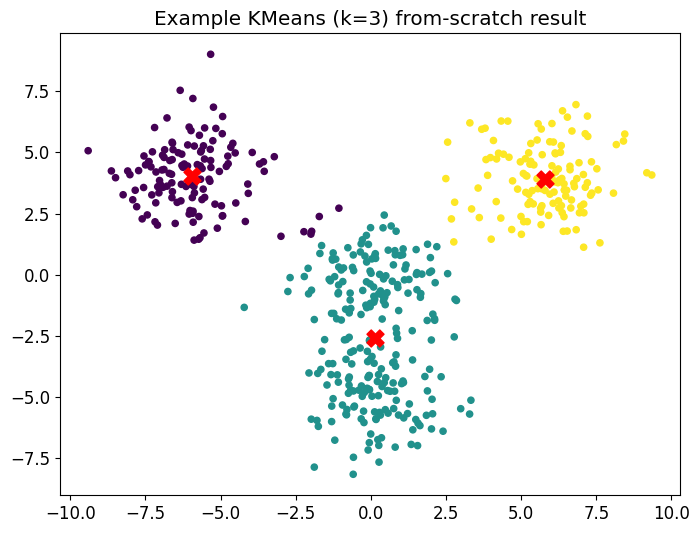

In [44]:
# ## KMeans implementation (from scratch)
# The class below implements:
# - KMeans++ initialization
# - Assignment step with NumPy distances
# - Update step (centroid means)
# - Inertia computation (WSS)
# - Early stopping when centroids don't move
class KMeansScratch:
    def __init__(self, k, max_iter=200, tol=1e-6, random_state=None):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.inertia_ = None
        self.random_state = random_state

    def fit(self, X):
        # initialize
        self.centroids = kmeans_plus_plus_init(X, self.k, random_state=self.random_state)

        for it in range(self.max_iter):
            # assign
            labels = np.argmin(euclidean_distance(X, self.centroids), axis=1)
            # update
            new_centroids = np.array([X[labels==i].mean(axis=0) if np.any(labels==i) else self.centroids[i]
                                      for i in range(self.k)])
            # check convergence
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                self.centroids = new_centroids
                break
            self.centroids = new_centroids

        # inertia (WSS)
        dists = np.min(euclidean_distance(X, self.centroids), axis=1)
        self.inertia_ = np.sum(dists**2)
        return labels

    def predict(self, X):
        return np.argmin(euclidean_distance(X, self.centroids), axis=1)

# quick run
km = KMeansScratch(k=3, random_state=RND)
labels = km.fit(X)
print('Inertia (example run):', km.inertia_)
plt.scatter(X[:,0], X[:,1], c=labels, s=20)
plt.scatter(km.centroids[:,0], km.centroids[:,1], color='red', s=150, marker='X')
plt.title('Example KMeans (k=3) from-scratch result')
plt.show()

In [46]:
# ## Manual silhouette score
# We compute silhouette for each point as `(b - a) / max(a,b)` where:
# - `a` = average intra-cluster distance
# - `b` = smallest average distance to points in another cluster

# This manual implementation uses our `euclidean_distance` function and avoids libraries.
def silhouette_manual(X, labels):
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    if k == 1:
        return 0.0

    n = X.shape[0]
    D = euclidean_distance(X, X)  # (n, n)
    sil = np.zeros(n)

    for i in range(n):
        label = labels[i]
        same_mask = (labels == label)
        # a: mean distance to other points in same cluster
        if np.sum(same_mask) > 1:
            a = np.mean(D[i, same_mask & (np.arange(n) != i)])
        else:
            a = 0.0
        # b: minimum mean distance to points in other clusters
        b = np.inf
        for other in unique_labels:
            if other == label:
                continue
            other_mask = (labels == other)
            if np.any(other_mask):
                dist_to_other = np.mean(D[i, other_mask])
                if dist_to_other < b:
                    b = dist_to_other
        sil[i] = (b - a) / max(a, b) if max(a, b) > 0 else 0.0

    return np.mean(sil)

# quick test
print('Silhouette example (k=3):', silhouette_manual(X, labels))

Silhouette example (k=3): 0.6411055935214377


K=2, Run=1, Seed=0, Inertia=9760.49, Silhouette=0.4743


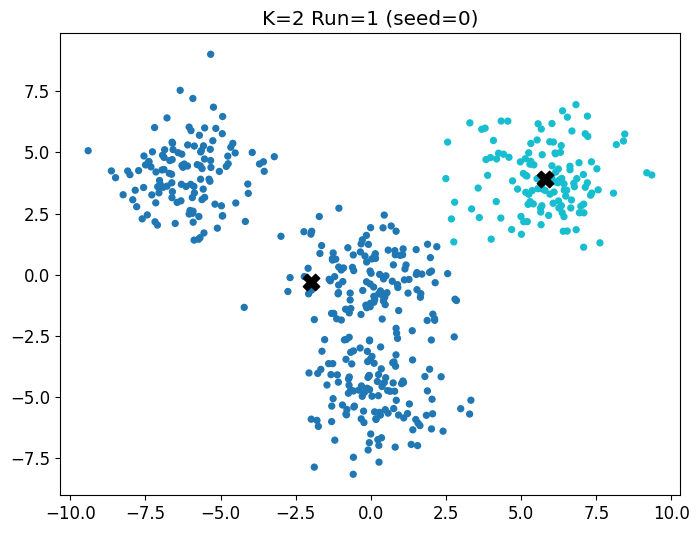

K=2, Run=2, Seed=7, Inertia=9153.54, Silhouette=0.5021


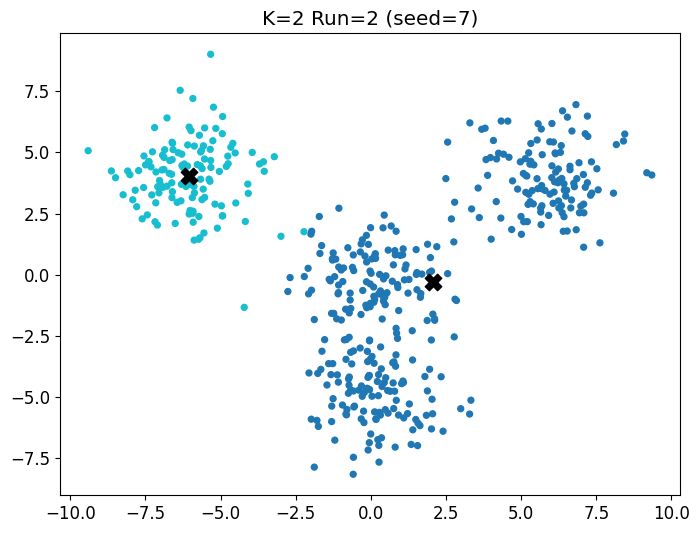

K=2, Run=3, Seed=21, Inertia=9760.49, Silhouette=0.4743


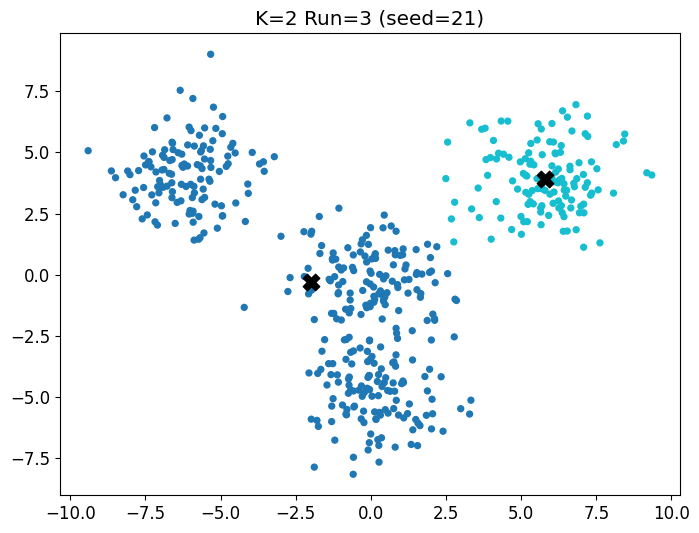

K=3, Run=1, Seed=0, Inertia=2952.78, Silhouette=0.6411


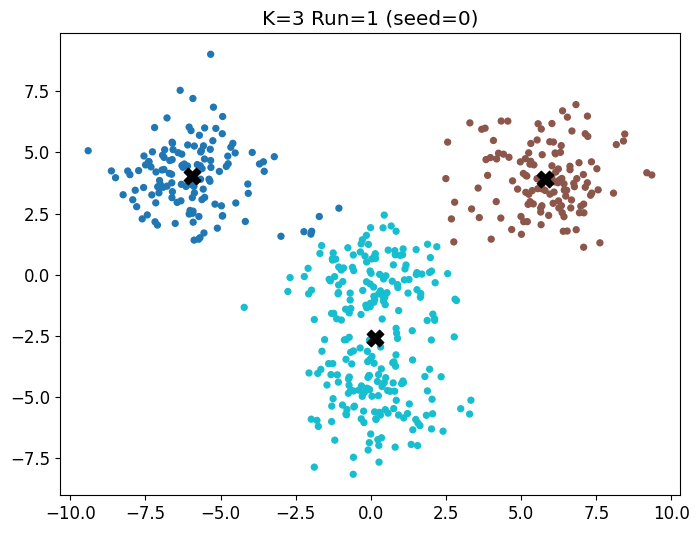

K=3, Run=2, Seed=7, Inertia=2952.78, Silhouette=0.6411


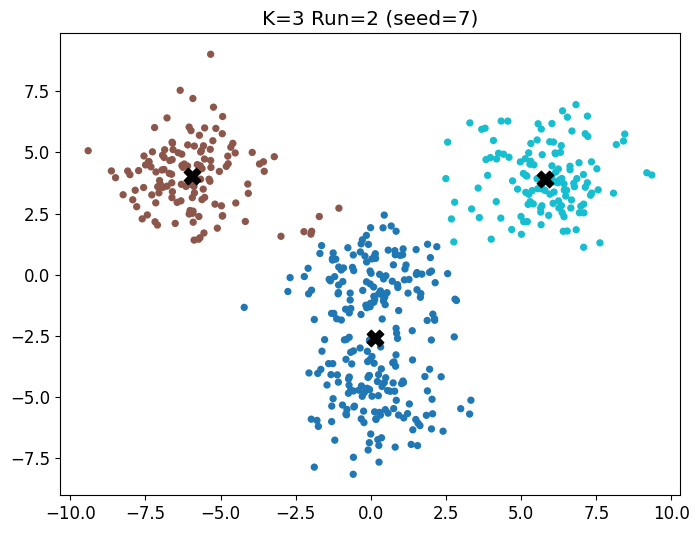

K=3, Run=3, Seed=21, Inertia=2952.78, Silhouette=0.6411


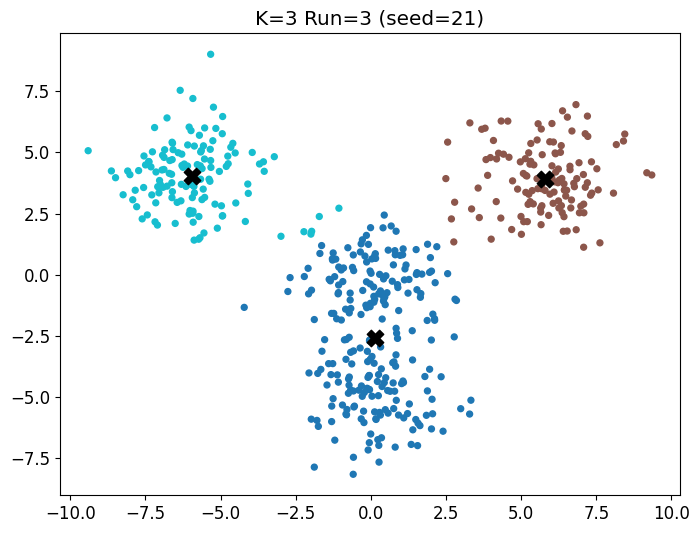

K=4, Run=1, Seed=0, Inertia=1567.29, Silhouette=0.6123


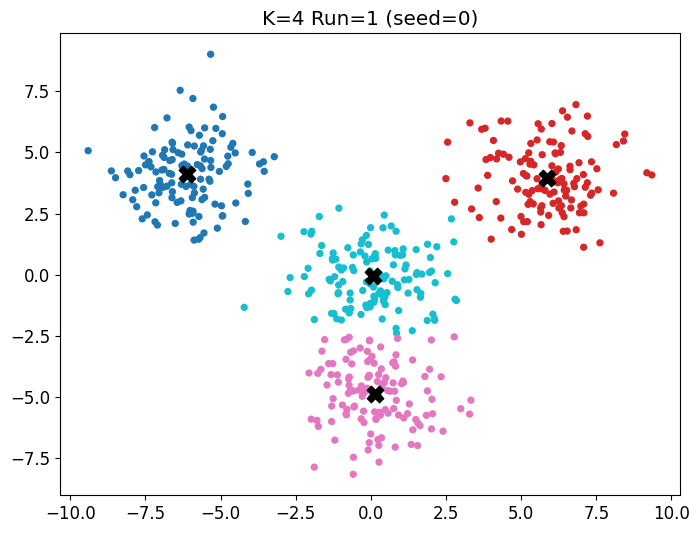

K=4, Run=2, Seed=7, Inertia=1567.29, Silhouette=0.6123


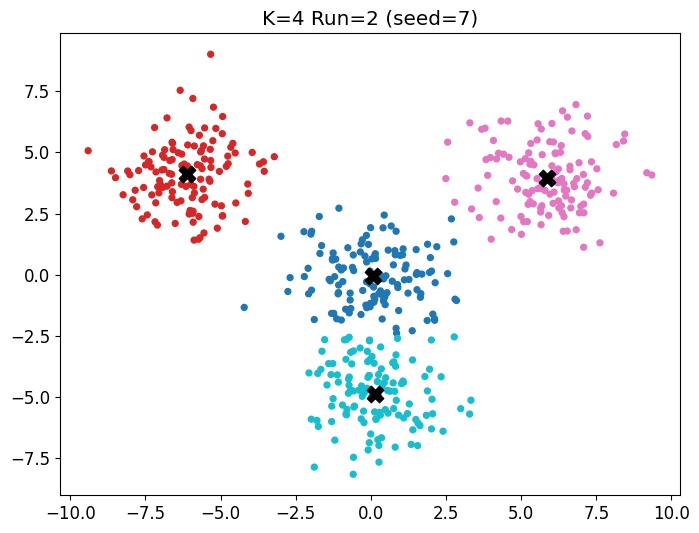

K=4, Run=3, Seed=21, Inertia=1567.29, Silhouette=0.6123


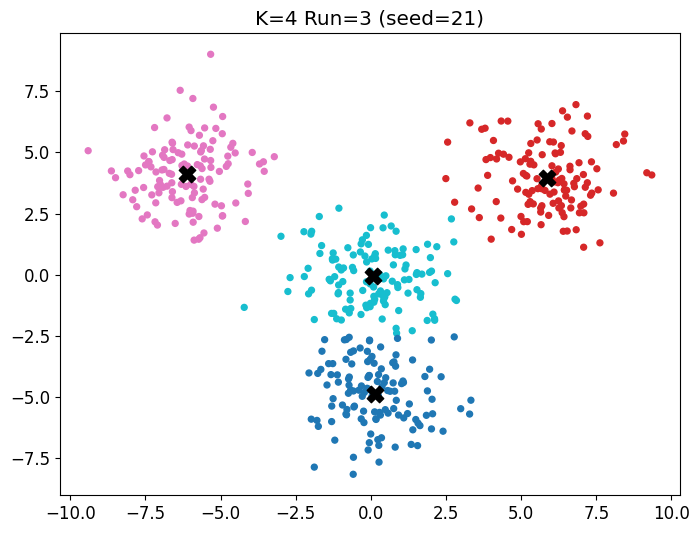

(   K  Run  Seed      Inertia  Silhouette
 0  2    1     0  9760.493592    0.474282
 1  2    2     7  9153.540434    0.502124
 2  2    3    21  9760.493592    0.474282
 3  3    1     0  2952.776116    0.641106
 4  3    2     7  2952.776116    0.641106
 5  3    3    21  2952.776116    0.641106
 6  4    1     0  1567.286512    0.612289
 7  4    2     7  1567.286512    0.612289
 8  4    3    21  1567.286512    0.612289,
        Inertia             Silhouette          
           mean         std       mean       std
 K                                              
 2  9558.175873  350.424569   0.483563  0.016075
 3  2952.776116    0.000000   0.641106  0.000000
 4  1567.286512    0.000000   0.612289  0.000000)

In [48]:
# ## Experiments: Run K = 2, 3, 4 (3 runs each)
# We run each K 3 times with different random seeds to show stability and compute summary statistics (mean inertia, std).
results = []
seeds = [0, 7, 21]
for k in [2, 3, 4]:
    for run_idx, s in enumerate(seeds, start=1):
        km = KMeansScratch(k=k, random_state=int(s))
        labels = km.fit(X)
        inertia = km.inertia_
        sil = silhouette_manual(X, labels)
        results.append({'K':k, 'Run':run_idx, 'Seed':int(s), 'Inertia':float(inertia), 'Silhouette':float(sil)})
        print(f"K={k}, Run={run_idx}, Seed={s}, Inertia={inertia:.2f}, Silhouette={sil:.4f}")
        # optional plot for each run
        plt.scatter(X[:,0], X[:,1], c=labels, s=18, cmap='tab10')
        plt.scatter(km.centroids[:,0], km.centroids[:,1], color='black', s=140, marker='X')
        plt.title(f'K={k} Run={run_idx} (seed={s})')
        plt.show()

# aggregate results
res_df = pd.DataFrame(results)
res_df_group = res_df.groupby('K').agg({'Inertia':['mean','std'],'Silhouette':['mean','std']})
res_df, res_df_group

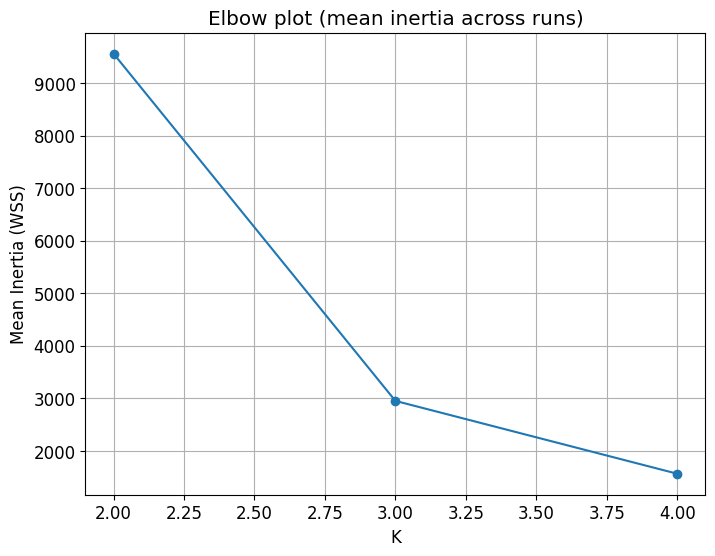

Summary table (mean ± std):
       Inertia             Silhouette          
          mean         std       mean       std
K                                              
2  9558.175873  350.424569   0.483563  0.016075
3  2952.776116    0.000000   0.641106  0.000000
4  1567.286512    0.000000   0.612289  0.000000


In [50]:
# ## Elbow plot (mean inertia across runs)
# We plot mean inertia vs K to inspect the elbow.
means = res_df.groupby('K')['Inertia'].mean().values
ks = sorted(res_df['K'].unique())
plt.plot(ks, means, marker='o')
plt.xlabel('K')
plt.ylabel('Mean Inertia (WSS)')
plt.title('Elbow plot (mean inertia across runs)')
plt.grid(True)
plt.show()

print('Summary table (mean ± std):')
print(res_df_group)